# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

# Import your chosen baseline model
import sksurv

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

from sklearn import set_config
from sklearn.preprocessing import OrdinalEncoder


from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

## Model Choice: Survival Analysis

[Explain why you've chosen a particular model as the baseline. This could be a simple statistical model or a basic machine learning model. Justify your choice.]

As one of the main goals is to predict the overall survival of AML-patients, the decision of a baseline-Model fell on building a survival Analysis model.

A survival Analysis model (build with scikit-survival sksurv) is a special kind of analysis. The Cox's proportional hazards model is kind of similar to regression but takes the cumulative hazards function in the presence of addidional covariants into account.
The Survival analysis describes a time-to event regression problem which is different to a regular regression due to "censoring". 

### Censoring
Censored data can occur as right censoring (event was not observed in timeframe), left censoring (event occured before start of the timeframe of a study) or interval censoring (event occured in an roughly described time interval, but the exact time is unknown)

The dataset of Acute Myeloic Leukemia (AML) patients contains medical and biological data, as well as a status of "alive" or "dead" on the last follow-up. The dataset is affected by "right censoring", which indicates that not every patient made it to the endpoint of data collection or didn't experience the "event" while the duration of the observation- timeframe. The left censoring also affects the given dataset, as some patients probably died before or right at the start of the observation timeframe. 

(For the application of the survival analysis with the scikit-survival package, some more tailored steps of data processing are required, compared to the regular processing of most other modelling packages. This means, the categorical data has to be encoded by usage of the One hot Encoder and the data hast to be compiled to arrays then, to run the survival analysis.)




In [ ]:
# load data and preview

import os

os.chdir("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics")

print(os.getcwd())

# Load the datasets

# Clinical Data

cln_df = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_clinical.csv"
)  # clinical_train
cln_eval = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_clinical_eval.csv"
)  # clinical_test

# Molecular Data
maf_df = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_molecular.csv"
)  # molecular_train
maf_eval = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_molecular_eval.csv"
)  # molecular_test

# Target Data (Outcome)
target_df = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_outcome.csv"
)  # target_train
target_df_test = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/ChallengeData/random_submission_FRacdcw_v9kP4pP.csv"
)  # target_test risk scores

/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics


In [3]:
# Preview the data

## Clinical

# number of rows and columns
print("Clinical Data Rows: ", cln_df.shape[0])
print("Clinical Data Columns: ", cln_df.shape[1])
print(cln_df.head())

## Molecular

# number of rows and columns
print("Molecular Data Rows: ", maf_df.shape[0])
print("Molecular Data Columns: ", maf_df.shape[1])
print(maf_df.head())

## Target

# number of rows and columns
print("Target Data Rows: ", target_df.shape[0])
print("Target Data Columns: ", target_df.shape[1])
print(target_df.head())

Clinical Data Rows:  3323
Clinical Data Columns:  9
        ID CENTER  BM_BLAST    WBC  ANC  MONOCYTES    HB    PLT  \
0  P132697    MSK      14.0    2.8  0.2        0.7   7.6  119.0   
1  P132698    MSK       1.0    7.4  2.4        0.1  11.6   42.0   
2  P116889    MSK      15.0    3.7  2.1        0.1  14.2   81.0   
3  P132699    MSK       1.0    3.9  1.9        0.1   8.9   77.0   
4  P132700    MSK       6.0  128.0  9.7        0.9  11.1  195.0   

                          CYTOGENETICS  
0      46,xy,del(20)(q12)[2]/46,xy[18]  
1                                46,xx  
2   46,xy,t(3;3)(q25;q27)[8]/46,xy[12]  
3    46,xy,del(3)(q26q27)[15]/46,xy[5]  
4  46,xx,t(3;9)(p13;q22)[10]/46,xx[10]  
Molecular Data Rows:  10935
Molecular Data Columns:  11
        ID CHR        START          END                REF ALT    GENE  \
0  P100000  11  119149248.0  119149248.0                  G   A     CBL   
1  P100000   5  131822301.0  131822301.0                  G   T    IRF1   
2  P100000   3   7

## Feature Selection

[Indicate which features from the dataset you will be using for the baseline model, and justify your selection.]

The overall survival prediction will be based on the generation of a risk score through the evaluation of the status (alive or dead) OS_STATUS, as event indicator and with the time measurements of survival in years OS_YEARS after last follow-up as time variable.

One of he main obstacles in working with censored data is choosing an unbiased estimator of the survival curve. There are different approaches like the Kaplan-Meyer survival probability.

Feature selection could be done randomly, or by differentiation of weighting risk-factors which would be highly desired in health-related fields.

Some main features of AML described in literature are the presence of blast cells in percentage (column 'BM_BLAST'), low concentration of Hemoglobine levels, resulting in anemia (column 'HB') as well as low levels of platelets (column 'PLT').

One of the main used models for survival predictions in the medical field is the Cox's proportional hazards model.

#### Survival function: S(t) 
- probability of an individual to survive longer than an specific time t:

$$S(t)=P(T > t)$$ 


#### Hazard function
- quantification of a risk of event occurence within a short time interval, when the individual lives up to a known time  t.

#### Cumulative hazard function
- the cumulative risk of occurence of an event up to the time t. 

#### Probability density function of survival time
- the probability of individuals to survive a short time interval.

In the recent years, several Machine Learning survival algorithms have been developed to handle complex and cencored time-to-event data. One of the established algorithms is named random survival forests


In [ ]:
# Data preparation

# Convert 'OS_YEARS' to numeric
target_df["OS_YEARS"] = pd.to_numeric(target_df["OS_YEARS"], errors="coerce")

# Convert 'OS_STATUS' to boolean (1 for event, 0 for censored)
target_df["OS_STATUS"] = target_df["OS_STATUS"].astype(bool)
print(target_df[["OS_YEARS", "OS_STATUS"]].dtypes)


# Select features in clinical data

features = ["BM_BLAST", "HB", "PLT"]
# Select target in target data
target = ["OS_YEARS", "OS_STATUS"]


# Create the survival data format required for the model

X = cln_df.loc[cln_df["ID"].isin(target_df["ID"]), features]
y = Surv.from_dataframe("OS_STATUS", "OS_YEARS", target_df)

OS_YEARS     float64
OS_STATUS       bool
dtype: object


In [ ]:
# Check shapes and types before splitting
print(X.shape, type(X))  # Should be (3173, n_features)
print(y.shape, type(y))

print(len(y))  # Should be 3173
print(len(X))

(3323, 3) <class 'pandas.core.frame.DataFrame'>
(3323,) <class 'numpy.ndarray'>
3323
3323


In [ ]:
# Create the survival data format

X = cln_df[features]
y = target_df[target]


# Check shapes before splitting
print(X.shape)  # Should be (3173, n_features)
print(len(y))  # Should be 3173
print(y.shape)
print(X.dtypes)
print(y.dtypes)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

(3323, 3)
3323
(3323, 2)
BM_BLAST    float64
HB          float64
PLT         float64
dtype: object
OS_YEARS     float64
OS_STATUS       bool
dtype: object


In [7]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[["BM_BLAST", "HB", "PLT"]] = imputer.fit_transform(
    X_train[["BM_BLAST", "HB", "PLT"]]
)
X_test[["BM_BLAST", "HB", "PLT"]] = imputer.transform(X_test[["BM_BLAST", "HB", "PLT"]])

In [8]:
# Group by OS_STATUS and count number of events
target_df_events = target_df.groupby("OS_STATUS")["OS_STATUS"].count()

pct_target_df_events = (
    target_df.groupby("OS_STATUS")["OS_STATUS"].count() / len(target_df) * 100
).round(1)

# Print the number of events, if true print "number of deaths", if false print "number of censored"
for events, count in target_df_events.items():
    if events == True:
        print(
            "Number of deaths:",
            count,
            ",",
            pct_target_df_events[True],
            "%",
            "target_df",
        )
    else:
        print(
            "Number of survivors:",
            count,
            ",",
            pct_target_df_events[False],
            "%",
            "target_df",
        )
print("Total number of samples:", len(target_df))

Number of survivors: 1573 , 47.3 % target_df
Number of deaths: 1750 , 52.7 % target_df
Total number of samples: 3323


The target_df dataframe consists of a total of 3323 patients. For 1750 patients, which equals 52.7 %, the occurence of the event "death" can be observed, whereas 1573 patients, which equals 47.3 % survive at least until the endpoint of data collection.

In [ ]:
# Check the shape of the dataframes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# check if datataframe or series
print("X_train type:", type(X_train))
print("X_test type:", type(X_test))
print("y_train type:", type(y_train))
print("y_test type:", type(y_test))

X_train shape: (2658, 3)
X_test shape: (665, 3)
y_train shape: (2658, 2)
y_test shape: (665, 2)
X_train type: <class 'pandas.core.frame.DataFrame'>
X_test type: <class 'pandas.core.frame.DataFrame'>
y_train type: <class 'pandas.core.frame.DataFrame'>
y_test type: <class 'pandas.core.frame.DataFrame'>


In [ ]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
# df = pd.read_csv("your_dataset.csv")

# Feature selection
# Example: Selecting only two features for a simple baseline model
# X = df[["feature1", "feature2"]]
# y = df["target_variable"]

# Splitting the dataset
# X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=42)

## Implementation

[Implement your baseline model here.]



In [11]:
# Initialize and train the baseline model
# Example for a classification problem using Logistic Regression
# model = LogisticRegression()
# model.fit(X_train, y_train)

# Your implementation code here

### Kaplan - Meier unconditional survival analysis
This method approaches the problem of estimatiobn of time-to-event from cecored data
The Kaplan - Meier curve shows the overall survival propability which is changing over time. At the start of the data collection it is close to one and almost all of the patients are still alive. Over time, the probability of survival decreases gradually due to the occurences of the event "death".

In [ ]:
import matplotlib.pyplot as plt

# Import the Kaplan-Meier fitter from lifelines

from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

print(type(y_train))
print(y_train)
print(type(y_test))
print(y_test)

<class 'pandas.core.frame.DataFrame'>
      OS_YEARS  OS_STATUS
2554  1.432877      False
1811  1.057534       True
2242  0.186301       True
729   0.000000      False
468   0.827397       True
...        ...        ...
1095  2.019178      False
1130  1.246575      False
1294  2.480713       True
860   0.117808      False
3174  4.271233       True

[2658 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
       OS_YEARS  OS_STATUS
2950   0.095890      False
430   11.019178      False
949    3.994521      False
1221   1.742466      False
51     2.728767       True
...         ...        ...
582    0.298630       True
810    8.128767      False
789    0.665753       True
2908   4.210959       True
56     0.594521       True

[665 rows x 2 columns]


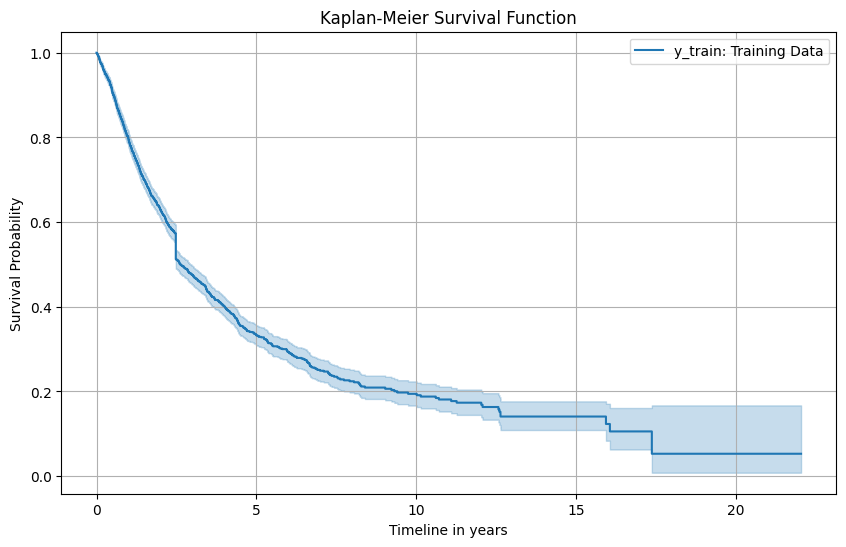

In [ ]:
# Apply Kaplan-Meier survival analysis to training data

kmf.fit(y_train["OS_YEARS"], event_observed=y_train["OS_STATUS"])

# Plot the kaplan-meier survival function of training data

plt.figure(figsize=(10, 6))
kmf.plot()
plt.xlabel("Timeline in years")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Survival Function")
plt.legend(["y_train: Training Data"])
plt.grid(True)
# plt.tight_layout()
plt.show()


# Evaluate the model

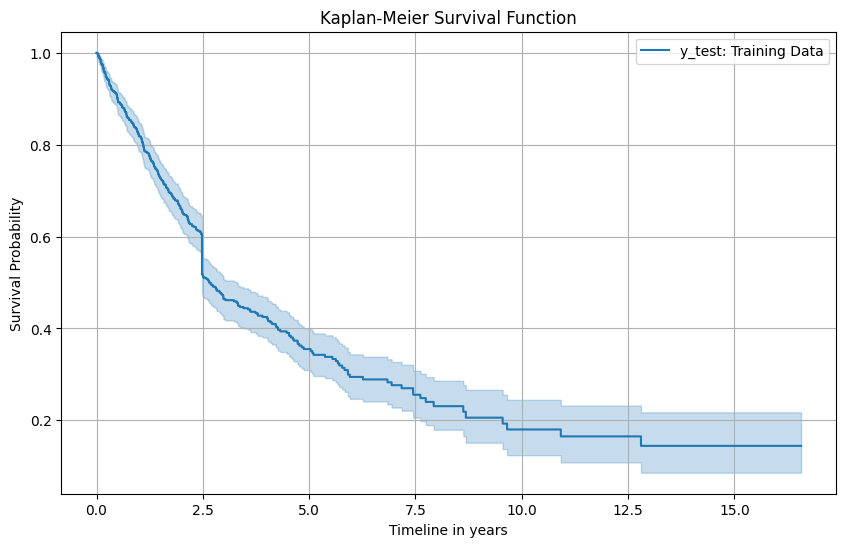

In [14]:
# Apply Kaplan-Meier survival analysis to test data

kmf.fit(y_test["OS_YEARS"], y_test["OS_STATUS"])

# Plot the kaplan-meier survival function of test data

plt.figure(figsize=(10, 6))
kmf.plot()


plt.xlabel("Timeline in years")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Survival Function")
plt.legend(["y_test: Training Data"])
plt.grid(True)
# plt.tight_layout()
plt.show()

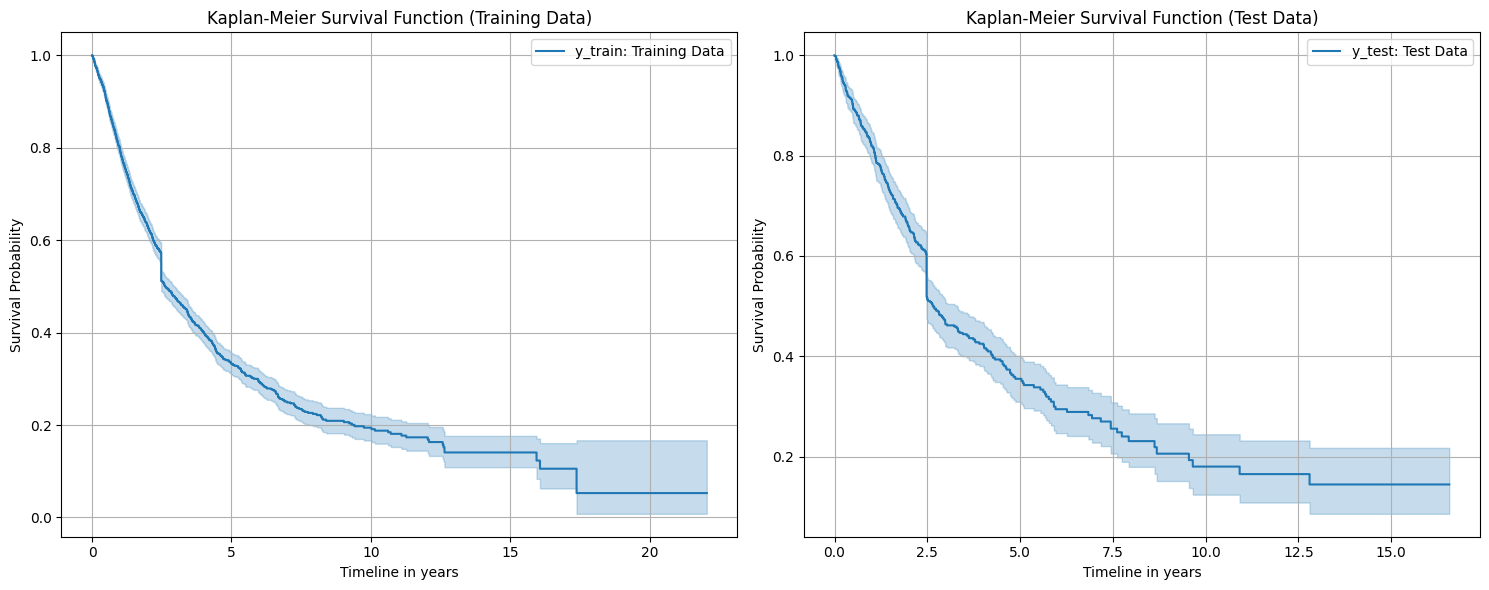

In [15]:
# plot the kaplan-meier survival function of training and test data next to each other

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

kmf.fit(y_train["OS_YEARS"], y_train["OS_STATUS"])
kmf.plot(ax=ax[0])
ax[0].set_title("Kaplan-Meier Survival Function (Training Data)")
ax[0].set_xlabel("Timeline in years")
ax[0].set_ylabel("Survival Probability")
ax[0].legend(["y_train: Training Data"])
ax[0].grid(True)

kmf.fit(y_test["OS_YEARS"], y_test["OS_STATUS"])
kmf.plot(ax=ax[1])
ax[1].set_title("Kaplan-Meier Survival Function (Test Data)")
ax[1].set_xlabel("Timeline in years")
ax[1].set_ylabel("Survival Probability")
ax[1].legend(["y_test: Test Data"])
ax[1].grid(True)

plt.tight_layout()
plt.show()

## Cox Proportional Hazards

In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv

from sksurv.metrics import concordance_index_ipcw

y_train_df = pd.DataFrame(y_train)
print(y_train_df)

      OS_YEARS  OS_STATUS
2554  1.432877      False
1811  1.057534       True
2242  0.186301       True
729   0.000000      False
468   0.827397       True
...        ...        ...
1095  2.019178      False
1130  1.246575      False
1294  2.480713       True
860   0.117808      False
3174  4.271233       True

[2658 rows x 2 columns]


In [ ]:
# create cox proportional hazards model

# Training features in X_train (dataframe)
cox_X_train = X_train

print(cox_X_train.shape)

# event/ time  columns in y_train (dataframe), but will be converted to structured array for survival analysis
cox_y_train = Surv.from_dataframe("OS_STATUS", "OS_YEARS", y_train_df)

print(cox_y_train.shape)

coxph = CoxPHSurvivalAnalysis()

# fit the cox proportional hazards model
coxph.fit(cox_X_train, cox_y_train)

(2658, 3)
(2658,)


CoxPHSurvivalAnalysis()

In [18]:
# prepare data for IPCW evaluation
print(type(y_test))
cox_y_test = Surv.from_dataframe("OS_STATUS", "OS_YEARS", y_test)

cox_X_test = X_test

<class 'pandas.core.frame.DataFrame'>


## Evaluation

[Clearly state what metrics you will use to evaluate the model's performance. These metrics will serve as a starting point for evaluating more complex models later on.]



## Concordance index (C-index)

The metric of the C-index evaluates a model by comparing pairs of individuals with the occurence of the event "death". 

The C-index returns volues between 0 and 1. A C-index of 0.5 corresponds to a random prediction.

In [19]:
# Evaluate the model using Concordance Index IPCW
from sksurv.metrics import concordance_index_ipcw


# Initialize and train the Cox Proportional Hazards model
coxph = CoxPHSurvivalAnalysis()
coxph.fit(cox_X_train, cox_y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(
    cox_y_train, cox_y_train, coxph.predict(cox_X_train), tau=7
)[0]
cox_cindex_test = concordance_index_ipcw(
    cox_y_train, cox_y_test, coxph.predict(cox_X_test), tau=7
)[0]

print(
    "Cox Proportional Hazard Model Concordance Index IPCW on train: {:.2f}".format(
        cox_cindex_train
    )
)
print(
    "Cox Proportional Hazard Model Concordance Index IPCW on test: {:.2f}".format(
        cox_cindex_test
    )
)

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.66
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.66


In [ ]:
# Evaluate the baseline model
# Example for a classification problem
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

# For a regression problem, you might use:
# mse = mean_squared_error(y_test, y_pred)



In [ ]:
# Neural Network approach

# train a neural network model using the baseline model
# %pip install tensorflow
import tensorflow as tf
from tensorflow import keras


# Define the model architecture
input_shape = X_train.shape[1:]


# Create the model

model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(64, activation="relu", input_shape=input_shape),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


# Train the model
model.fit(X_train, y_train["OS_STATUS"], epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5040 - loss: 1.9650 - val_accuracy: 0.5357 - val_loss: 0.7336
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5258 - loss: 0.8334 - val_accuracy: 0.5545 - val_loss: 0.6933
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5572 - loss: 0.6978 - val_accuracy: 0.5357 - val_loss: 0.6806
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5799 - loss: 0.7010 - val_accuracy: 0.5526 - val_loss: 0.7006
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5862 - loss: 0.6932 - val_accuracy: 0.5545 - val_loss: 0.6901
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5860 - loss: 0.6922 - val_accuracy: 0.5414 - val_loss: 0.7512
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5841 - loss: 0.6952 - val_accuracy: 0.5545 - val_loss: 0.6936
Epoch 8/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5680 - loss: 0.8051 - val_accuracy: 0.5376 - val_loss:

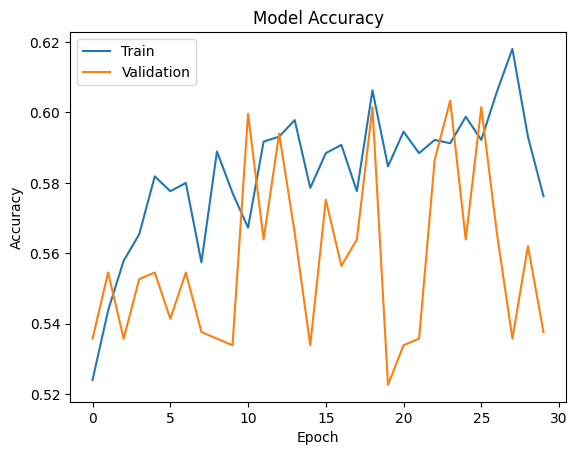

In [44]:
# plot accuracy of the model

# plot the accuracy of the model
plt.plot(model.history.history["accuracy"])
plt.plot(model.history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [45]:
# test the model
y_pred = model.predict(X_test)


# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test["OS_STATUS"])
mse = mean_squared_error(y_test["OS_STATUS"], y_pred)
mae = mean_absolute_error(y_test["OS_STATUS"], y_pred)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6108 - loss: 0.7401 


In [46]:
# summarize the model
model.summary()
# Evaluate the model
from sklearn.metrics import accuracy_score, mean_squared_error

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Test mean squared error:", mse)
print("Test mean absolute error:", mae)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,109 (27.77 KB)

 Trainable params: 2,369 (9.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,740 (18.52 KB)

Test loss: 0.7469058632850647
Test accuracy: 0.5759398341178894
Test mean squared error: 0.26221632957458496
Test mean absolute error: 0.46683230996131897


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# calculate mean absolute error mae
mae = mean_absolute_error(y_test["OS_YEARS"], y_pred)

print("Mean Absolute Error mae:", mae)


# calculate root mean squared error rmse
rmse = np.sqrt(mean_squared_error(y_test["OS_YEARS"], y_pred))

print("Root Mean Squared Error rmse:", rmse)

Mean Absolute Error mae: 2.3047080751812277
Root Mean Squared Error rmse: 3.4194878452681543


In [ ]:
import keras
import matplotlib.pyplot as plt
import seaborn as sns


# Plot the accuracy of the model
plt.figure(figsize=(10, 6))
sns.lineplot(x=history.history["accuracy"], label="Train")
sns.lineplot(x=history.history["val_accuracy"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy of the Model")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'history' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
# evaluation of different models